# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

Let's start our analysis by scaling the data using StandardScaler so that it can be used for Principal Component Analysis. We will choose to go with 10 components at the beginning and then we will figure out if we need less by looking at the elbow chart and by printing out the explained variance ratio.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
firstComponentQuestions = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

scaler = StandardScaler()
scaler.fit(df)
X_scaled= scaler.transform(df)

# We choose ten components, but we will adjust that later in the process
pca = PCA(n_components = 10)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))


Original shape: (867, 49)
Reduced shape: (867, 10)


As you can see the data still has 867 rows, but it now has only 10 feautres which were created by the PCA.

In [3]:
import numpy
print(f"The ratio of 10 components: {[round(x, 4) for x in pca.explained_variance_ratio_]}")
print(f"This is how much information is explained in those ten components: {round(numpy.sum(pca.explained_variance_ratio_),4)}")

The ratio of 10 components: [0.4174, 0.1026, 0.0498, 0.043, 0.0293, 0.0237, 0.0199, 0.0169, 0.0167, 0.016]
This is how much information is explained in those ten components: 0.7354


Hmm 73% variance explained in 10 components, that's pretty good result considering that we started with 49 features. Let's have a look at the elbow plot to show that in a different way.

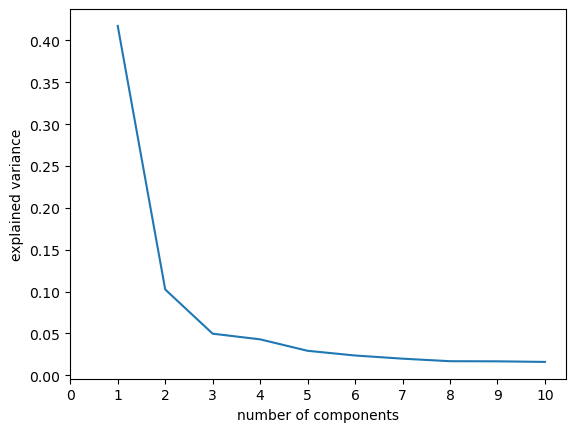

In [4]:
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

Oh okay, that's look interesting. One can clearly see that the first three components are rather vertical than horizontal, thus they give a lot of value by explaining the variance of the dataset - and as we know variance equals information! We can also see that from 4th component the curve is becoming horizontal so the components do not bring much value. We could try to include only three components, let's see what will be the explained variance ratio for those.

In [5]:
import numpy
pca3 = PCA(n_components = 3)
pca3.fit(X_scaled)
X_pca3 = pca3.transform(X_scaled)
print(f"The ratio of 3 components: {[round(x, 4) for x in pca3.explained_variance_ratio_]}")
print(f"This is how much information is explained in those three components: {round(numpy.sum(pca3.explained_variance_ratio_),4)}")


The ratio of 3 components: [0.4174, 0.1026, 0.0498]
This is how much information is explained in those three components: 0.5697


Well that's a lot of percent but we are also little bit far from the desired 70%. I suppose a better idea would be to include more components, like seven or so. In this case, we will go with 10 as we are not using this on any models. However, if we were to use this on a model, we would definitely try out different number of components to see how it affects my model. Let's say we would start by taking 5 components which explain 70% of the data and see how the model performs. Later we would take 15 components which explain 90% and see if the model slows down or if it is overfitting.

Now we will try to understand what do the first and the second component mean. We will try to find which features from the initial dataset have contributed the most to those components. Moreover, we will try to figure out if they are concering a similar area. Later we will compare that to the political compass - a way to rate political ideology in a spectrum with two axes: one about economic policy and another about social policy. 

In [6]:
components = pca.components_
explained_variance = pca.explained_variance_
feature_names = df.columns

# Print the contribution of each feature to the components
important_features = []
num_features = X_scaled.shape[1]
for i in range(2):
    print(f"Principal Component {i+1}:")
    component_features = [(feature_names[j], components[i][j]) for j in range(num_features)]
    component_features.sort(key=lambda x: abs(x[1]), reverse=True)
    top_5_features = component_features[:5]
    important_features.append(top_5_features)
    for feature, coefficient in top_5_features:
        print(f"{feature}: {coefficient}")


Principal Component 1:
530: -0.19064057165736892
537: 0.19028423253957694
4a: -0.18884915210395284
3b: -0.18877782945374091
550: -0.18855512478366523
Principal Component 2:
10b: 0.3029172768119701
556: -0.2979777451908913
551: 0.2938356874232328
553: 0.27280742404917246
4b: 0.2584494471442466


Wow that looks interesting! Now we have the first five questions that had the highest impact on components. Let's see what are thos questions.

In [43]:
drq = pd.read_excel('drq.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')

q530 = drq.loc[drq['ID']==530]
q537 = drq.loc[drq['ID']==537]
q550 = drq.loc[drq['ID']==550]
q4a = tv2q.loc[tv2q['id']=='4a']
q3b = tv2q.loc[tv2q['id']=='3b']

firstComponentQuestions = pd.DataFrame({
    "ID":[q530['ID'].iloc[0], q537['ID'].iloc[0], q4a['id'].iloc[0], q3b['id'].iloc[0], q550['ID'].iloc[0]],
    "Area": [q530['Title'].iloc[0], q537['Title'].iloc[0], q4a['header'].iloc[0], q3b['header'].iloc[0], q550['Title'].iloc[0]],
    "Question" : [q530['Question'].iloc[0], q537['Question'].iloc[0], q4a['question'].iloc[0], q3b['question'].iloc[0], q550['Question'].iloc[0]]
})
pd.set_option('display.max_colwidth', None)     
firstComponentQuestions.head() 

,ID,Area,Question
0,530,KLIMA OG ENERGI,Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje
1,537,VELFÆRD,"Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere"
2,4a,Økonomi,Den økonomiske ulighed i det danske samfund bør mindskes.
3,3b,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.
4,550,ARBEJDSMARKED OG ØKONOMI,"Der skal indføres kvoter, der sikrer mindst 30 procent kvinder i virksomheders bestyrelser"


530: Denmark must spend more money on strengthening train and bus operations rather than building new motorways.     
537: It is okay for economic inequality to increase as long as the Danes generally become richer.    
4a: The economic inequality in Danish society should be reduced.    
3b: Development aid should be increased.    
550: Quotas must be introduced to ensure at least 30 percent women on company boards.     
  
We can clearly see that those question are mostly regarding economics, development and welfare of the Danes. We believe that it fits with the first political compass axes which is also economics. Let's take a look at the second component.

In [42]:
q556 = drq.loc[drq['ID']==556]
q551 = drq.loc[drq['ID']==551]
q553 = drq.loc[drq['ID']==553]
q10b = tv2q.loc[tv2q['id']=='10b']
q4b = tv2q.loc[tv2q['id']=='4b']

firstComponentQuestions = pd.DataFrame({
    "ID":[q556['ID'].iloc[0], q551['ID'].iloc[0], q10b['id'].iloc[0], q4b['id'].iloc[0], q553['ID'].iloc[0]],
    "Area": [q556['Title'].iloc[0], q551['Title'].iloc[0], q10b['header'].iloc[0], q4b['header'].iloc[0], q553['Title'].iloc[0]],
    "Question" : [q556['Question'].iloc[0], q551['Question'].iloc[0], q10b['question'].iloc[0], q4b['question'].iloc[0], q553['Question'].iloc[0]]
})
pd.set_option('display.max_colwidth', None)     
firstComponentQuestions.head() 

,ID,Area,Question
0,556,ARBEJDSMARKED OG ØKONOMI,Den såkaldte Arne-pension skal afskaffes
1,551,EU OG UDENRIGS,Der skal være permanent grænsekontrol mellem Danmark og Tyskland
2,10b,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft."
3,4b,Økonomi,"Staten bør i højere grad kompensere danskerne for de stigende priser, som inflationen har medført."
4,553,UDDANNELSE,Der skal udflyttes flere uddannelsespladser fra de store byer


556: The so-called Arne pension must be abolished.     
551: There must be permanent border control between Denmark and Germany.            
10b: The so-called Arne pension, which allows for earlier retirement, must be maintained, even if there is a shortage of labour.         
4b: The state should compensate the Danes to a greater extent for the rising prices that inflation has brought about.       
553: More education places must be relocated from the big cities.         

We believe that those questions cover a wide range of social aspects of the Danish community. Therefore, we also think that it fits perfectly with the second axes from the political compass which is social policy. 

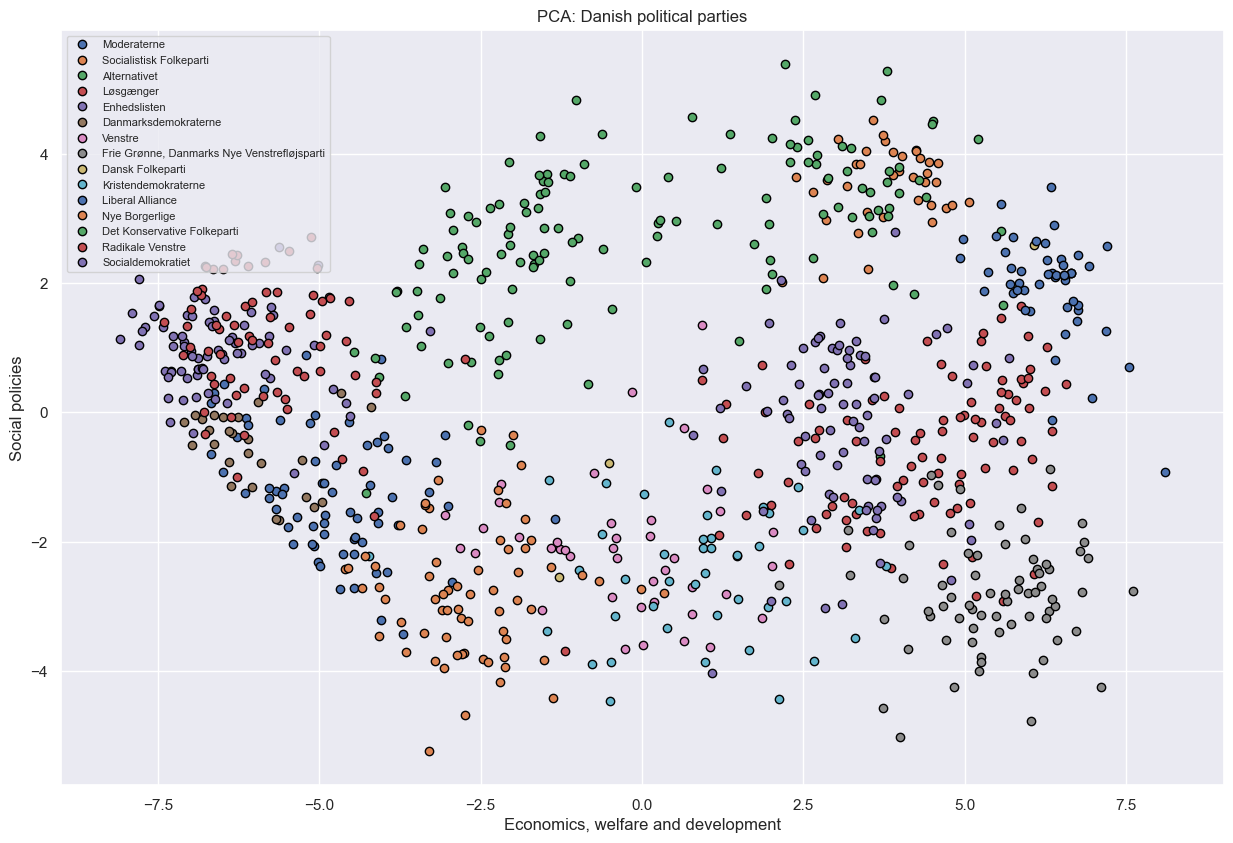

In [62]:
# plt.figure(figsize=(16, 12))
# mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels, markeredgewidth=1)
# plt.legend(labels.unique(), loc="upper left", fontsize=8)
# plt.gca().set_aspect("equal")
# plt.xlabel("Economics, welfare and development")
# plt.ylabel("Social policies")
# plt.title("PCA: Danish political parties")
# plt.grid(True)
# plt.show()
# box_colors = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']
# unique_labels_sorted = sorted(labels.unique())

#mglearn can't set colors of markers and other solutions didn't work so seemlessly

plt.figure(figsize=(15, 12))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels, s=6, markers='o')
plt.legend(labels.unique(), loc="upper left", fontsize=8)  # Smaller legend font size
plt.gca().set_aspect("equal")
plt.xlabel("Economics, welfare and development")
plt.ylabel("Social policies")
plt.title("PCA: Danish political parties")
plt.grid(True)
plt.show()



That is interesting! Parties such as Enhedslisten and Radikale Venstre which are left wing parties are indeed on the left side of the plot. Liberal Alliance which is considered to be a right wing party is on the right side of the plot as it alings nicely with their economic point of view. Nye Borgerlige considered to be far-right are on the right side of the plot. We believe that this plot aligns nicely with the political compass and it also shows the beliefs of each party are correctly visualized on the graph. Maybe it could hint that there are too many parties in left wing as well as in the right wing as it is pretty crowded there meaning that the candidates share similiar opinions while being in different parties. Let's see what our next step which is clustering will tell us!

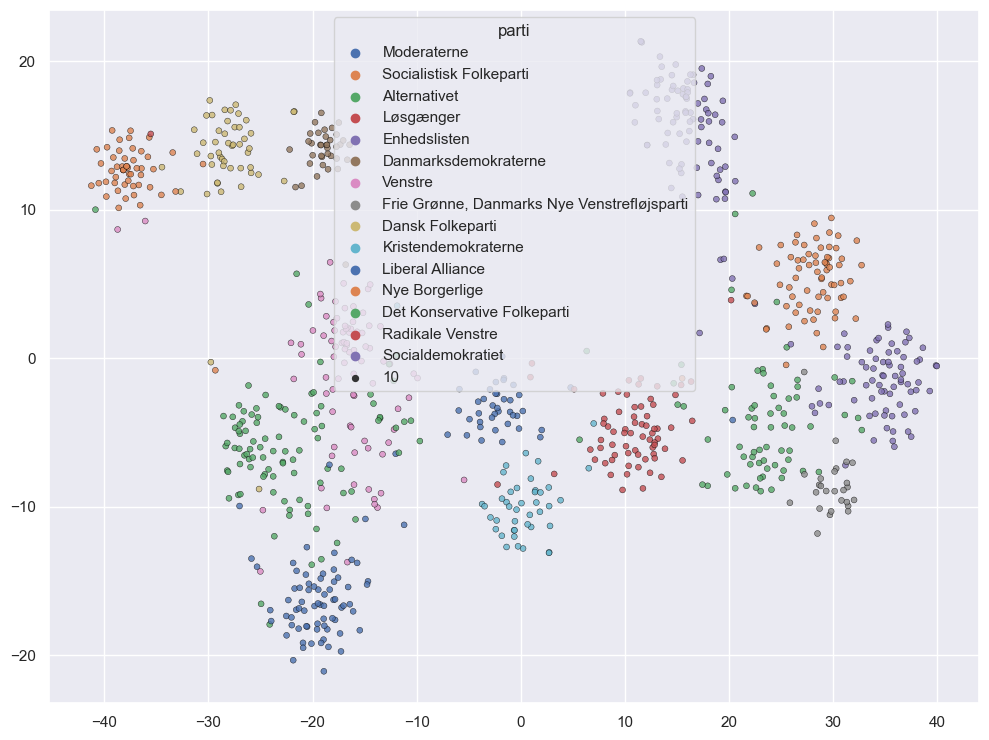

In [72]:
from matplotlib import colors
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
politcal_tsne = tsne.fit_transform(df)
# box_colors = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']

def visualize_2d(x, labels):
    sns.set_theme(rc={'figure.figsize':(12,9)})
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette='deep', s=100, alpha=0.8, edgecolor="black", size=10, )
    
visualize_2d(politcal_tsne, labels)

Here is TSNE as a fun fact. It does a great work in visualizing the parties and their candidates in their groups.

Lets's take a look at the disagreements within the elected candidates. For that I will reuse the method from the first assignment on the candidates. This method calculates the distances between each candidates.

In [10]:
elected_df = pd.read_excel('electeddata.xlsx')
data_only_questions_and_parti = elected_df.drop(['navn', 'alder', 'storkreds'], axis=1)
data3 = data_only_questions_and_parti.drop(['parti'], axis=1)

total_differences = []

# This function calculates differences between each of the candidates (1st to 2nd, 1st to 3rd... etc.)           
def differenceCalculator(data):
    n = len(data)
    # Pre-calculate properties to avoid repeated function calls
    properties = {'navn': elected_df['navn'], 'parti': elected_df['parti']}
    
    for i in range(n):
        person1 = data.iloc[i]
        name1, party1 = properties['navn'][i], properties['parti'][i]
        for j in range(i + 1, n):
            person2 = data.iloc[j]
            name2, party2 = properties['navn'][j], properties['parti'][j]
            # In this line we subtract each question and then sum those differences
            # absoluteValue of (-1-2) = 3 and so on... (don't agree - strongly agree)
            difference = abs(person1 - person2).sum() 
            total_differences.append((i, j, name1, name2, party1, party2, difference))
    return total_differences

differenceCalculator(data3)

# Convert the list of differences to DataFrame
differences_df = pd.DataFrame(total_differences, columns=['id1', 'id2','candidate1','candidate2', 'parti1', 'parti2', 'totalDifference'])


Okay, now let's consider the interparty disagreements.

In [11]:
differences_df.sort_values(by='totalDifference', ascending=False).head(10)

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
6651,45,127,Peder Hvelplund,Sandra Elisabeth Skalvig,Enhedslisten,Liberal Alliance,141
5356,35,107,Ole Birk Olesen,Karina Lorentzen Dehnhardt,Liberal Alliance,Socialistisk Folkeparti,140
6669,45,145,Peder Hvelplund,Steffen Frølund,Enhedslisten,Liberal Alliance,140
6630,45,106,Peder Hvelplund,Henrik Dahl,Enhedslisten,Liberal Alliance,140
2434,15,35,Charlotte Broman Mølbæk,Ole Birk Olesen,Socialistisk Folkeparti,Liberal Alliance,139
12324,107,127,Karina Lorentzen Dehnhardt,Sandra Elisabeth Skalvig,Socialistisk Folkeparti,Liberal Alliance,139
6684,45,160,Peder Hvelplund,Steffen Larsen,Enhedslisten,Liberal Alliance,139
6633,45,109,Peder Hvelplund,Niels Flemming Hansen,Enhedslisten,Det Konservative Folkeparti,138
6598,45,74,Peder Hvelplund,Mai Mercado,Enhedslisten,Det Konservative Folkeparti,138
5294,35,45,Ole Birk Olesen,Peder Hvelplund,Liberal Alliance,Enhedslisten,138


Peter Hvelplund seems to be a pearson that is the most disagreed with. This is also no surprise that the most conservative left wing party has a lot of dissagreements with right wing parties.

How about internal disagreements?

In [12]:
diff_intra = differences_df[differences_df['parti1'] == differences_df['parti2']]
display(diff_intra.sort_values(by='totalDifference', ascending=False).head(10)) 

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
6355,43,78,Mette Reissmann,Bjørn Brandenborg,Socialdemokratiet,Socialdemokratiet,77
5063,33,81,Jon Læssøe Stephensen,Jeppe Søe,Moderaterne,Moderaterne,70
6430,43,153,Mette Reissmann,Fie Thorsted Hækkerup,Socialdemokratiet,Socialdemokratiet,70
6410,43,133,Mette Reissmann,Frederik Vad,Socialdemokratiet,Socialdemokratiet,69
12839,116,138,Benny Engelbrecht,Mette Gjerskov,Socialdemokratiet,Socialdemokratiet,69
6338,43,61,Mette Reissmann,Simon Kollerup,Socialdemokratiet,Socialdemokratiet,68
5086,33,104,Jon Læssøe Stephensen,Henrik Frandsen,Moderaterne,Moderaterne,68
5107,33,125,Jon Læssøe Stephensen,Charlotte Bagge Hansen,Moderaterne,Moderaterne,67
12867,116,166,Benny Engelbrecht,Maria Durhuus,Socialdemokratiet,Socialdemokratiet,67
6517,44,116,Ida Margrete Meier Auken,Benny Engelbrecht,Socialdemokratiet,Socialdemokratiet,67


Metter Reissmann from Socialdemokratiet has a lot of dissagrements with various colleagues from her party. This is also the case for Jon Laessoee Stephensen in Moderaterne. Those two parties seems to have high degree of internal disagreements.

What about the candidates from different parties that agree the most?

In [13]:
diff_inter = differences_df[differences_df['parti1'] != differences_df['parti2']]
display(diff_inter.sort_values(by='totalDifference', ascending=True).head(10)) 

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
211,1,45,Torsten Gejl,Peder Hvelplund,Alternativet,Enhedslisten,15
4473,29,37,Pelle Dragsted,Carl Valentin,Enhedslisten,Socialistisk Folkeparti,19
44,0,45,Karsten Hønge,Peder Hvelplund,Socialistisk Folkeparti,Enhedslisten,19
5760,38,118,Lisbeth Bech-Nielsen,Trine Pertou Mach,Socialistisk Folkeparti,Enhedslisten,19
1,0,2,Karsten Hønge,Mai Villadsen,Socialistisk Folkeparti,Enhedslisten,19
369,2,37,Mai Villadsen,Carl Valentin,Enhedslisten,Socialistisk Folkeparti,20
493,2,161,Mai Villadsen,Sigurd Agersnap,Enhedslisten,Socialistisk Folkeparti,20
346,2,14,Mai Villadsen,Sofie Lippert,Enhedslisten,Socialistisk Folkeparti,20
370,2,38,Mai Villadsen,Lisbeth Bech-Nielsen,Enhedslisten,Socialistisk Folkeparti,20
94,0,95,Karsten Hønge,Søren Egge Rasmussen,Socialistisk Folkeparti,Enhedslisten,20


The left wing parties have the most in common, in particular Enhedslisten and Socialist Folkeparti. Mai Villadsen is a person that agrees with 5 candidates from Socialistisk Folkeparti. That could suggest that she might be in that party instead. If you take a look at the PCA plot it can also be seen there that those two parties have a lot in common.

And finally how about the highest degree of internal agreements?

In [73]:
differences_df.sort_values(by='totalDifference', ascending=True).head(10)

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
8924,65,150,Lea Wermelin,Rasmus Stoklund,Socialdemokratiet,Socialdemokratiet,1
12387,108,130,Pernille Vermund,Peter Seier Christensen,Nye Borgerlige,Nye Borgerlige,1
7829,55,130,Kim Edberg,Peter Seier Christensen,Nye Borgerlige,Nye Borgerlige,2
10349,80,150,Trine Bramsen,Rasmus Stoklund,Socialdemokratiet,Socialdemokratiet,2
7807,55,108,Kim Edberg,Pernille Vermund,Nye Borgerlige,Nye Borgerlige,3
8854,65,80,Lea Wermelin,Trine Bramsen,Socialdemokratiet,Socialdemokratiet,3
1142,6,156,Jakob Ellemann-Jensen,Karen Ellemann,Venstre,Venstre,3
13858,142,156,Sophie Løhde,Karen Ellemann,Venstre,Venstre,4
10848,86,142,Thomas Danielsen,Sophie Løhde,Venstre,Venstre,5
10862,86,156,Thomas Danielsen,Karen Ellemann,Venstre,Venstre,5


Those three parties seems to have the least internal disagreements. Candidates from venstre seems to agree a lot as well as candidates from Nye Borgerlige and Socialdemokratiet.